In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [32]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting
import rw_models
import joblib

# Simulation behavior check

In [33]:
# load 4 models simulated data
sim_basic = pd.read_csv('../data/simulated_basic.csv')
sim_context = pd.read_csv('../data/simulated_context.csv')
sim_outcome = pd.read_csv('../data/simulated_outcome.csv')
sim_valence = pd.read_csv('../data/simulated_valence.csv')

In [34]:
sim_basic

,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,lr,beta,model
0,0,0,0,0,1.0,-1.0,1.0,numberbar_mixed,-1.000000,0.500000,0.445386,2.810468,sim_basic
1,0,0,1,0,1.0,-1.0,1.0,numberbar_mixed,-0.554614,0.222399,0.445386,2.810468,sim_basic
2,0,0,2,1,0.0,1.0,1.0,numberbar_mixed,1.000000,0.875007,0.445386,2.810468,sim_basic
3,0,0,3,1,0.0,1.0,1.0,numberbar_mixed,0.554614,0.960748,0.445386,2.810468,sim_basic
4,0,0,4,1,0.0,1.0,1.0,numberbar_mixed,0.307597,0.980003,0.445386,2.810468,sim_basic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22990,218,2,30,1,0.0,0.0,0.0,numberbar_pos,-0.598650,0.587976,0.131901,0.994115,sim_basic
22991,218,2,31,0,1.0,1.0,0.0,numberbar_pos,0.759061,0.431163,0.131901,0.994115,sim_basic
22992,218,2,32,0,1.0,1.0,0.0,numberbar_pos,0.658940,0.455722,0.131901,0.994115,sim_basic
22993,218,2,33,0,1.0,1.0,0.0,numberbar_pos,0.572025,0.477223,0.131901,0.994115,sim_basic


In [36]:
# make a function to map blocks to block_type and sort as categorical
def block_type(df):
    df['block_type'] = df['blocks'].map({'numberbar_pos':'reward', 'numberbar_mixed':'mix', 'numberbar_neg':'punishment'})
    df['block_type'] = pd.Categorical(df['block_type'], categories=['punishment', 'mix', 'reward'])
    df['optimal_L'] = df['opt_act'].map({0:1, 1:0})
    # compute the optimal action if choice_L == optimal_L (1) or not (0)
    df['optimal'] = (df['optimal_L'] == df['choices_L']).astype(int)
    return df

sim_basic = block_type(sim_basic)
sim_context = block_type(sim_context)
sim_outcome = block_type(sim_outcome)
sim_valence = block_type(sim_valence)

In [37]:
# make the above plottings into a function
def plot_subject(sub_df, subject, model):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for i, ax in enumerate(axs):
        block_df = sub_df[sub_df['block']==i]
        ax.plot(block_df['trial'], block_df['choices_L'], 'o')
        ax.plot(block_df['trial'], block_df['optimal_L'], '-')
        ax.set_title(block_df['block_type'].iloc[0])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Choice (Left)')

        # block optimal mean
        opt_mean = block_df['optimal'].mean()
        ax.axhline(opt_mean, color='black', linestyle='--')
        ax.axhline(y=0.5, color='black', linestyle='-')
    
    axs[-1].legend(['Choice', 'Optimal (Left)'])
    plt.suptitle(f'Subject {subject} - {model["model"][0]}')

In [38]:
# randomly select a subject to visualize simulated data
subject = np.random.randint(0, 219)
mod = sim_basic  

sub_df = mod[mod['subject']==subject]
sub_df['trial'] += 1
sub_df.head()

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,lr,beta,model,block_type,optimal_L,optimal
11970,114,0,1,1,0.0,1.0,0.0,numberbar_mixed,1.000000,0.500000,0.53725,2.408782,sim_basic,mix,1,0
11971,114,0,2,0,1.0,1.0,0.0,numberbar_mixed,1.000000,0.215157,0.53725,2.408782,sim_basic,mix,1,1
11972,114,0,3,0,1.0,-1.0,0.0,numberbar_mixed,-1.537250,0.500000,0.53725,2.408782,sim_basic,mix,1,1
11973,114,0,4,1,0.0,-1.0,0.0,numberbar_mixed,-1.537250,0.879678,0.53725,2.408782,sim_basic,mix,1,0
11974,114,0,5,0,1.0,1.0,0.0,numberbar_mixed,1.288637,0.500000,0.53725,2.408782,sim_basic,mix,1,1


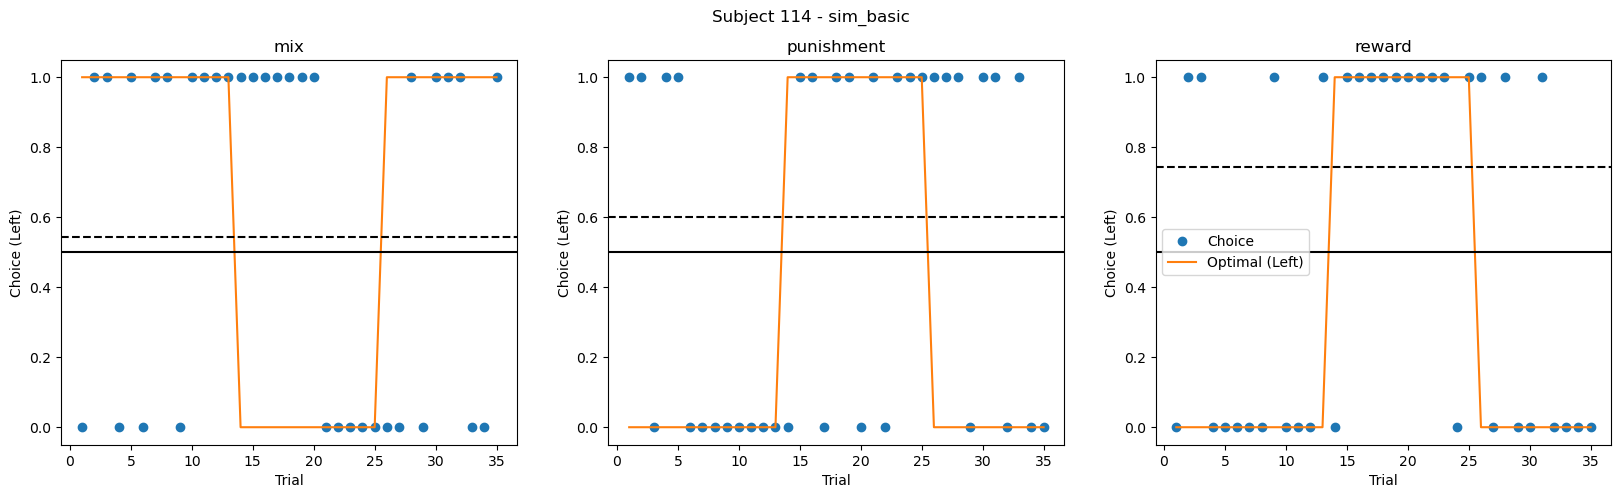

In [39]:
plot_subject(sub_df, subject, mod)

In [40]:
def plot_optimal(sim_df):
    sim_sub_level = sim_df.groupby(['subject', 'block_type'])['optimal'].mean().reset_index()
    sns.boxplot(data=sim_sub_level, x='block_type', y='optimal')
    sns.lineplot(data=sim_sub_level, x='block_type', y='optimal', color='red', errorbar=('se', 1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel('block')
    plt.title(sim_df['model'][0])
    sns.despine()

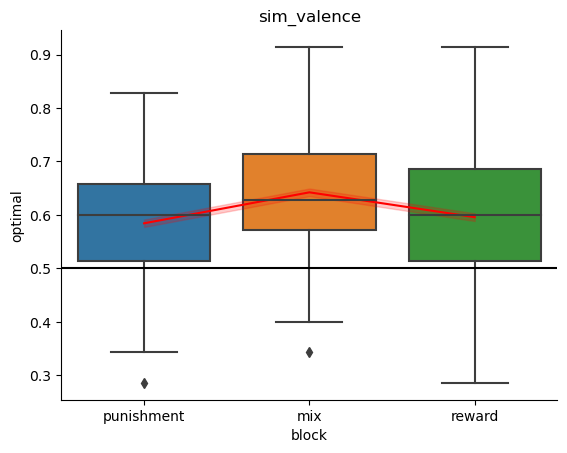

In [44]:
plot_optimal(sim_valence)

In [49]:
# visualize optimal choice as a function of learning rate
def plot_optimal_lr(sim_df, param):
    sim_sub_level = sim_df.groupby(['subject', 'block_type', param])['optimal'].mean().reset_index()
    sns.lineplot(data=sim_sub_level, x=param, y='optimal', hue='block_type', errorbar=('se',1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel('Learning Rate')
    plt.title(sim_df['model'][0])
    sns.despine()

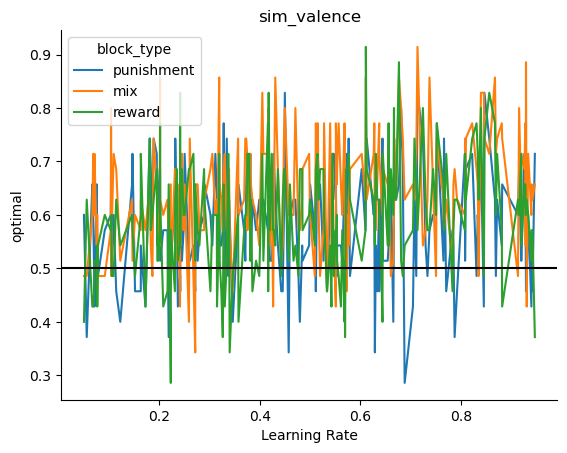

In [58]:
plot_optimal_lr(sim_valence, 'alpha_pos')